In [1]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
import SpaGCN as spg
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import metrics

/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: 

In [3]:
adata = sc.read_h5ad('../data/MERFISH/MERFISH_0.09.h5ad')
# adata = sc.read_h5ad('../data/BaristaSeq/Slice_3_removed.h5ad')
# adata = sc.read_h5ad('../data/osmfish/osmfish_remove_excluded.h5ad')
print("adata 形状:", adata.shape)

adata 形状: (5557, 155)


In [3]:
x_pixel = adata.obsm['spatial'][:,0]
y_pixel = adata.obsm['spatial'][:,1]
print(len(x_pixel))
adj = spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)
print("adata 形状:", adata.shape)

4839
Calculateing adj matrix using xy only...
adata 形状: (4839, 33)


In [4]:
adata.var_names_make_unique()
spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [5]:
p=0.5 
#Find the l value given p
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.19678008556365967, 49.41864580148864]
Run 2: l [0.01, 500.005], p [0.19678008556365967, 13.538657188415527]
Run 3: l [0.01, 250.0075], p [0.19678008556365967, 3.567620277404785]
Run 4: l [0.01, 125.00874999999999], p [0.19678008556365967, 0.9306051731109619]
Run 5: l [62.509375, 125.00874999999999], p [0.3412642478942871, 0.9306051731109619]
Run 6: l [62.509375, 93.7590625], p [0.3412642478942871, 0.5699372291564941]
Run 7: l [78.13421875, 93.7590625], p [0.4393423795700073, 0.5699372291564941]
recommended l =  85.946640625


In [6]:
n_clusters = len(adata.obs['Region'].unique())
print(n_clusters)
#Set seed
r_seed=t_seed=n_seed=100
#Seaech for suitable resolution
print("adata 形状:", adata.shape)
print("adj 形状:", adj.shape)
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

11
adata 形状: (4839, 33)
adj 形状: (4839, 4839)
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  7
Initializing cluster centers with louvain, resolution =  0.7999999999999999
Epoch  0
Epoch  10
Res =  0.7999999999999999 Num of clusters =  9
Res changed to 0.7999999999999999
Initializing cluster centers with louvain, resolution =  0.8999999999999999
Epoch  0
Epoch  10
Res =  0.8999999999999999 Num of clusters =  8
Res changed to 0.8999999999999999
Initializing cluster centers with louvain, resolution =  0.9999999999999999
Epoch  0
Epoch  10
Res =  0.9999999999999999 Num of clusters =  11
recommended res =  0.9999999999999999


In [7]:
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obsm['feature'] = prob
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')

Initializing cluster centers with louvain, resolution =  0.9999999999999999
Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
Epoch  50
Epoch  60
Epoch  70
Epoch  80
delta_label  0.0049597024178549285 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 88


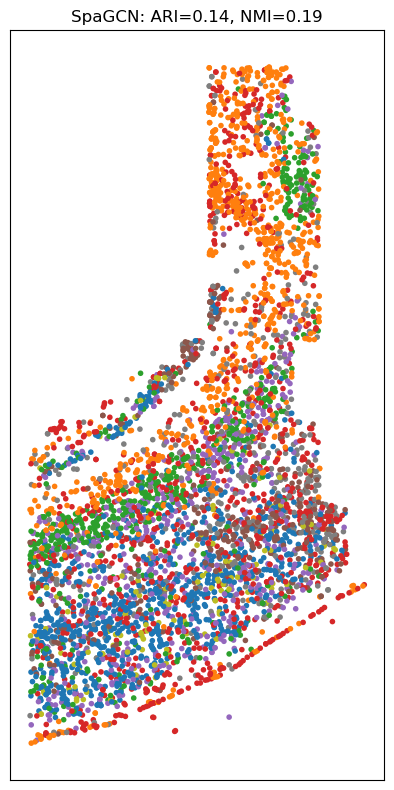

In [8]:
sub_adata = adata[~pd.isnull(adata.obs['Region'])]
ARI = metrics.adjusted_rand_score(sub_adata.obs['Region'], sub_adata.obs['pred'])
NMI = metrics.normalized_mutual_info_score(sub_adata.obs['Region'], sub_adata.obs['pred'])
fig, axes = plt.subplots(1,1,figsize=(6, 8))
sc.pl.spatial(adata, color='pred', ax=axes, show=False, spot_size=20, size=20, color_map='viridis',legend_loc=None)
axes.set_title('SpaGCN: ARI=%.2f, NMI=%.2f' % (ARI, NMI))
axes.set_xlabel('')
axes.set_ylabel('')
plt.tight_layout()
output_dir = ('./spagcn_ARI_NMI')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, "spagacn_osmfish_ARI.svg")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

In [9]:
output_dir1 = ('../featrue/osmish')
if not os.path.exists(output_dir1):
    os.makedirs(output_dir1)
output_path = os.path.join(output_dir1, f"SpaGCN.h5ad")
adata.write_h5ad(output_path)

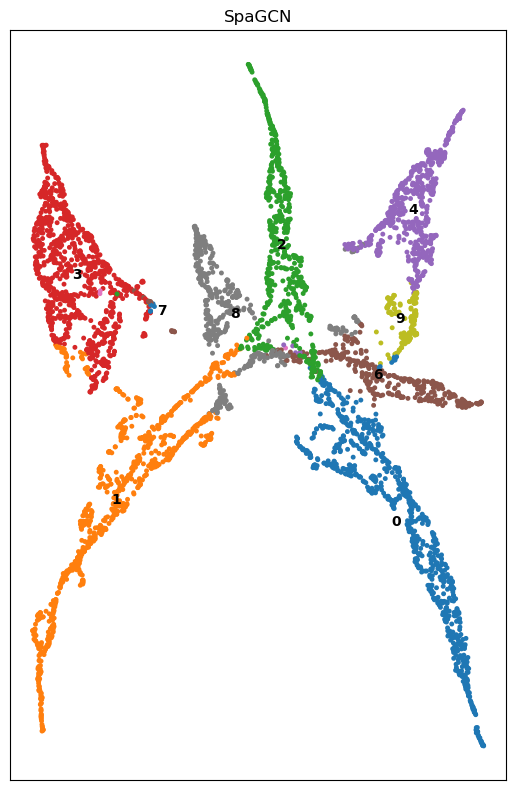

In [12]:
sc.pp.neighbors(adata, use_rep='feature', metric='cosine')
sc.tl.umap(adata, min_dist=0.2, spread=0.4)

fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sc.pl.umap(adata, color='pred', ax=axes, show=False, size=50,legend_loc=None)

axes.set_title('SpaGCN')
axes.set_aspect(1)


for cluster in adata.obs['pred'].unique():
    # 计算每个类别的 UMAP 中心点
    cluster_points = adata[adata.obs['pred'] == cluster].obsm['X_umap']
    x_mean, y_mean = cluster_points[:, 0].mean(), cluster_points[:, 1].mean()

    # 在中心点处添加标签
    axes.text(
        x=x_mean,  # X 坐标
        y=y_mean,  # Y 坐标
        s=cluster,  # 标签内容
        fontsize=10,
        ha='center',  # 水平对齐
        va='center',  # 垂直对齐
        color='black',  # 标签颜色
        fontweight='bold'  # 标签字体加粗
    )
axes.set_xlabel('')
axes.set_ylabel('')
plt.tight_layout()
output_path = os.path.join('./clustering_results', f"spagacn_osmfish.svg")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()